## Plot decode examples

In [1]:
%reload_ext autoreload
%autoreload 2

In [14]:
import os
import spyglass as nd
import pandas as pd
import spikeinterface as si

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import multiprocessing

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection
from spyglass.common.common_position import IntervalLinearizedPosition

import spyglass.spikesorting as ss
from spyglass.spikesorting import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.decoding.clusterless import (UnitMarks,
                                           UnitMarkParameters,UnitMarksIndicatorSelection,
                                          UnitMarksIndicator)
from spyglass.common.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection

from ripple_detection import Kay_ripple_detector
from ripple_detection.core import gaussian_smooth, get_envelope,get_multiunit_population_firing_rate
from ripple_detection.detectors import Kay_ripple_detector


# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import (TrialChoice,
                                   TrialChoiceReplay,
                                            find_ripple_peaks,
                                            RippleTimes,
                                   Decode,get_linearization_map,
                                   find_ripple_times,classify_ripples,classify_ripple_content,
                                   get_Kay_ripple_consensus_trace,load_everything,plot_decode_spiking)

In [151]:
# the only cell to be edited
nwb_file_name = 'molly20220418.nwb'
pos_interval_list_name = 'pos 5 valid times'
interval_list_name='06_Seq2Session3'

In [152]:
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)

#### Load Decode, position, LFP, and spiking data

In [153]:
(linear_position_df,decode,ripple_nwb,
 ripple_timestamps,ripple_times,
 recordings,neural_ts,
 mua,mua_time)=load_everything(nwb_copy_file_name,
                interval_list_name,
                pos_interval_list_name)

In [154]:
linear_map,welllocations=get_linearization_map()
wellnames=list(welllocations.keys())[1:]
wells=list(welllocations.values())
_,linear_map_ind,__=np.intersect1d(linear_map[:,1],wells[1:],return_indices=True)
linear_map_ind

array([3, 5, 7, 9])

In [161]:
#ripple_times

1650311769.4400225

### Plot examples

In [202]:
def plot_decode_lfp(t0t1,    #ripple start and end time
                        linear_position_df, # animal's location
                        results, #decode
                        recordings,neural_ts, #spiking data
                        ripple_nwb,ripple_timestamps,#ripple
                        offset=1, #2 second window
                        title='',
                        savefolder=[],savename=[]): 
    lfp_band_sampling_rate=1000
    plottimes=[t0t1[0]-offset,t0t1[1]+offset]
    ripple_times_in_plot=[]
    
    for i in ripple_times.index:
        op=ripple_times.loc[i].start_time
        ed=ripple_times.loc[i].end_time
        within=np.logical_and(op>=plottimes[0],ed<=plottimes[1])
        if within:
            ripple_times_in_plot.append([op,ed])
    
    fig, axes = plt.subplots(2, 1, figsize=(offset/0.2*6, 12), sharex=True, 
                             constrained_layout=True, gridspec_kw={"height_ratios": [1, 4.5]},)

    time_slice = slice(plottimes[0], plottimes[1])
    
    '''Ripple band data'''
    ripple_t_ind = np.argwhere(np.logical_and(ripple_timestamps >= plottimes[0], 
                                              ripple_timestamps < plottimes[1])).ravel()
    ripple_data = ripple_nwb['artifact removed filtered data'].data[ripple_t_ind,:].astype('int32')
    ripple_time = ripple_timestamps[ripple_t_ind]
    axes[0].plot(ripple_time,ripple_data[:,0])
    axes[0].set_title('ripple LFP',size=30)
    axes[0].axis('off')

    '''Decode and Position data'''
    results.sel(time=time_slice).acausal_posterior.sum('state').plot(x='time',
                                                                     y='position',
                                                                     ax=axes[1],
                                                                     robust=True, cmap='bone_r',
                                                                     vmin=0, vmax=0.3)
    axes[1].scatter(linear_position_df.loc[time_slice].index,
                    linear_position_df.loc[time_slice].linear_position.values,
                    s=10, color='C1', zorder=10)
    axes[1].scatter([linear_position_df.loc[time_slice].index[0],
                     linear_position_df.loc[time_slice].index[0]],
                [0,1000],s=10, color='C1', zorder=10)
    
    axes[0].set_title(title+'\n'+'ripple start time (s):'+str(t0t1[0]),size=20)
    
    for w in range(len(linear_map_ind)):
        plt.axhline(y=linear_map[linear_map_ind[w],0],linestyle='dotted',lw=0.3,color='k')
        plt.axhline(y=linear_map[linear_map_ind[w],1],linestyle='dotted',lw=0.3,color='k')

    plt.axhline(y=0,linestyle='dotted',lw=0.5,color='k')
    plt.axhline(y=linear_map[1,1],linestyle='dotted',lw=0.5,color='k')
    
    for r in range(len(ripple_times_in_plot)):
        t0t1_=ripple_times_in_plot[r]
        axes[0].axvspan(t0t1_[0],t0t1_[1], zorder=-1, alpha=0.3, color='paleturquoise')
        axes[1].axvspan(t0t1_[0],t0t1_[1], zorder=10, alpha=0.3, color='paleturquoise')
    
    xticks=np.arange(plottimes[0],plottimes[0]+2*offset+t0t1[1]-t0t1[0],0.10009)
    #xticks=np.linspace(plottimes[0],plottimes[0]+0.5+0.001,6)
    axes[1].set_xticks(xticks)
    axes[1].set_xticklabels([int(i*1000) for i in xticks-plottimes[0]])
    axes[1].set_xlabel('ms')
    
    axes[1].get_yaxis().set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['bottom'].set_visible(False)
    axes[1].spines['left'].set_visible(False)
    
    if len(savefolder)>0:
        plt.savefig(os.path.join(savefolder,savename+'.png'),bbox_inches='tight',dpi=300)
    #plt.savefig(os.path.join(exampledir,'ripple_'+str(ripple_num)+'.png'),bbox_inches='tight',dpi=300)
 

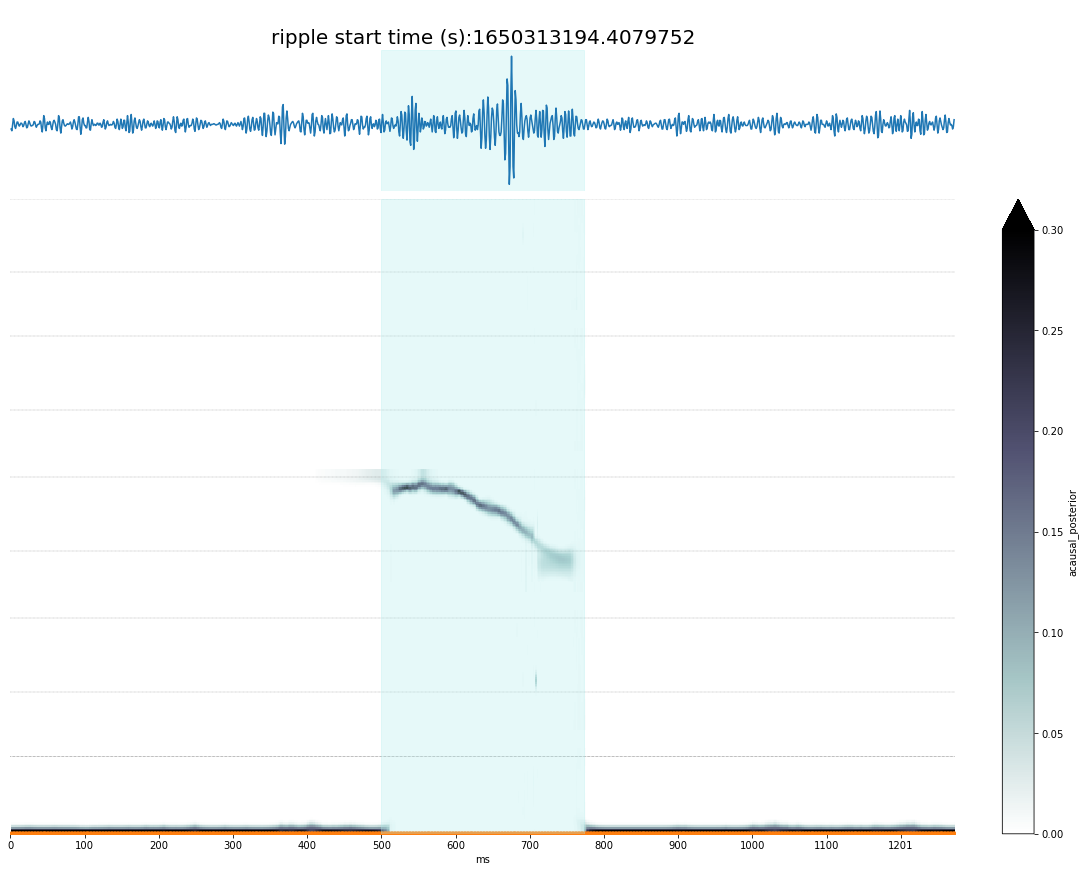

In [225]:
ripple_num = 1031
t0t1 = [ripple_times.loc[ripple_num].start_time,
        ripple_times.loc[ripple_num].end_time] 
plot_decode_lfp(t0t1,    #ripple start and end time
                    linear_position_df,
                    decode, #decode result
                    recordings,neural_ts, #spiking data
                    ripple_nwb,ripple_timestamps,#ripple
                    offset=0.5, #window=2*offset second 
                    savefolder=[],savename=[])